# 读取`MEIC`清单2017年0.25°格点数据，并依照污染物画图

导入需要的库

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

定义函数一：提取污染物并相加

In [2]:
def read_and_sum_files(folder_path, keyword):
    """
    读取所有名称为“2017_00_**_*.asc”的文件，并将这些 DataFrame 的值相加得到一个新的 DataFrame。
    :param folder_path: 文件夹路径
    :param keyword: 匹配文件名中的关键字（不同种类的污染物）
    :return: DataFrame 对象，包含所有文件数据的总和
    """
    
    # 找到所有符合条件的文件
    pattern = f"2017_00_*_{keyword}.asc"
    file_list = fnmatch.filter(os.listdir(folder_path), pattern)

    # 读取所有文件的数据，并进行相加
    df_sum = None
    for filename in file_list:
        file_path = os.path.join(folder_path, filename)
        #读取元信息
        meta=pd.read_csv(file_path,delim_whitespace=True,header=None,nrows=6)
        NODATA_value = meta.iloc[5,1]
        
        df = pd.read_csv(file_path, skiprows=6, header=None, delim_whitespace=True, na_values=NODATA_value)
        if df_sum is None:
            df_sum = df
        else:
            df_sum = df_sum + df

    return df_sum

定义函数二：绘制安庆市范围填色图

In [14]:
def pollutants_map(keyword,data,dpi,colormap,colormax,ncolor):
    """
    读取加和后的污染物数据并绘制空间分布图。
    :param keyword: 污染物种类
    :param data: 绘图数据源
    :param dpi: 绘图分辨率
    :param colormap: 绘图色标
    :param colormax: 绘图色标上限
    :param ncolor: 绘图色标颜色总数
    :return: DataFrame 对象，包含所有文件数据的总和
    """
    
    # 地图设置
    shp_CN=Reader('F:/shp_for_ArcGis/ChinaAdminDivisonSHP-master/1. Country/country.shp')
    shp_PR=Reader('F:/shp_for_ArcGis/ChinaAdminDivisonSHP-master/2. Province/province.shp')
    shp_CT=Reader('F:/shp_for_ArcGis/ChinaAdminDivisonSHP-master/3. City/city.shp')
    shp_DT=Reader('F:/shp_for_ArcGis/ChinaAdminDivisonSHP-master/4. District/district.shp')
    shp_AQ=Reader('F:/shp_for_ArcGis/安徽/安庆/Anqing.shp')
    
    proj=ccrs.PlateCarree()
    fig = plt.figure(figsize=(8,6),dpi=dpi)
    ax = fig.subplots(1,1,subplot_kw={'projection':proj})

    ax.add_feature(cfeat.ShapelyFeature(shp_DT.geometries(),proj,edgecolor='gray',facecolor='None'), linewidth=0.6)
    ax.add_feature(cfeat.ShapelyFeature(shp_CT.geometries(),proj,edgecolor='k',facecolor='None'), linewidth=0.8)
    ax.add_feature(cfeat.ShapelyFeature(shp_PR.geometries(),proj,edgecolor='k',facecolor='None'), linewidth=1)
    ax.add_feature(cfeat.ShapelyFeature(shp_AQ.geometries(),proj,edgecolor='tab:blue',facecolor='None'), linewidth=2)
    # ax.set_extent([115.7, 117.3, 29.7, 31.3],ccrs.PlateCarree())
    ax.set_extent([114.9, 118.1, 29.2, 32.1],ccrs.PlateCarree())

    labelsize=10
    gl=ax.gridlines(
        xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
        draw_labels=True, x_inline=False, y_inline=False,
        linewidth=0, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels =False
    gl.rotate_labels=False
    gl.xlabel_style={'size':labelsize}
    gl.ylabel_style={'size':labelsize}
    
    # 数据设置
    ncols = 320
    nrows = 200
    xllcorner = 70
    yllcorner = 10
    cellsize = 0.25
    
    # 创建X和Y坐标数组
    x = np.arange(xllcorner, xllcorner + ncols*cellsize, cellsize)
    y = np.arange(yllcorner + nrows*cellsize, yllcorner, -cellsize)

    # 创建网格数据
    lon, lat = np.meshgrid(x, y)

    # 绘制等高线图
    cm=ax.pcolormesh(lon, lat, data, cmap=colormap,vmin=0,vmax=colormax)
    levels=np.linspace(0,colormax,ncolor)
    cbar = plt.colorbar(cm, orientation='vertical', shrink=1, aspect=30, ticks=levels)

    # 添加标题和轴标签
    ax.set_title('MEIC2017_'+keyword)
    
    plt.show()

定义函数三：将前两个函数结合

In [10]:
def combining(folder_path, keyword, dpi, colormap, colormax, ncolor):
    
    pollutants_map(keyword,read_and_sum_files(folder_path, keyword),dpi,colormap,colormax,ncolor)

In [5]:
import cmaps

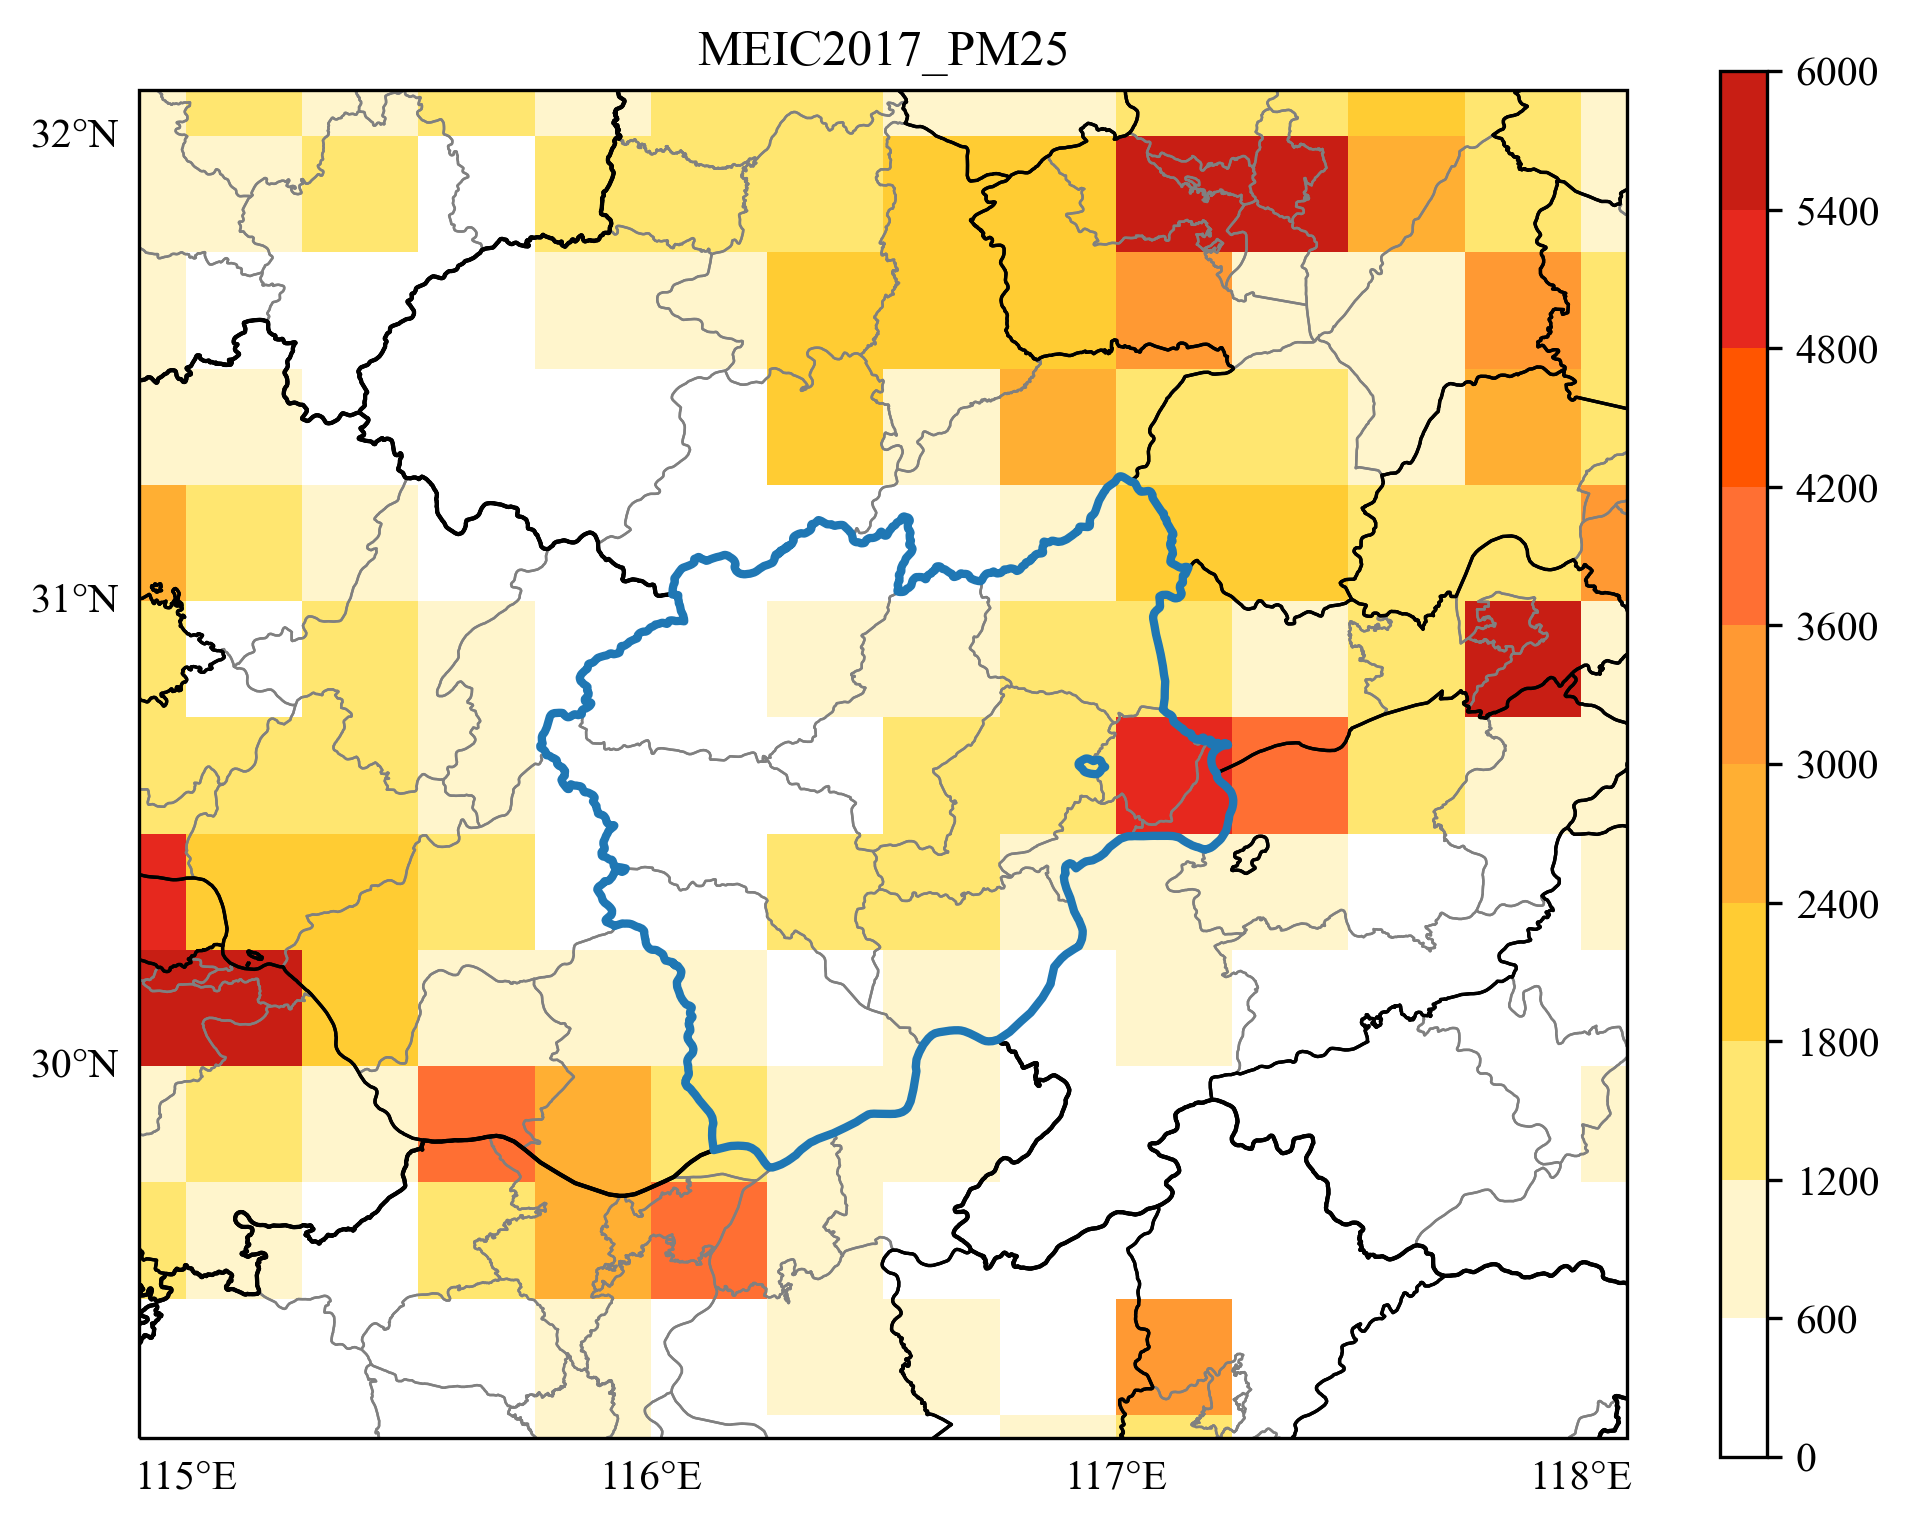

In [15]:
combining(folder_path='F:/Data/MEIC_2017_SAPRC07_0.25/',
          keyword='PM25',
          dpi=300,
          colormap=cmaps.sunshine_9lev,
          colormax=6000,
          ncolor=11)

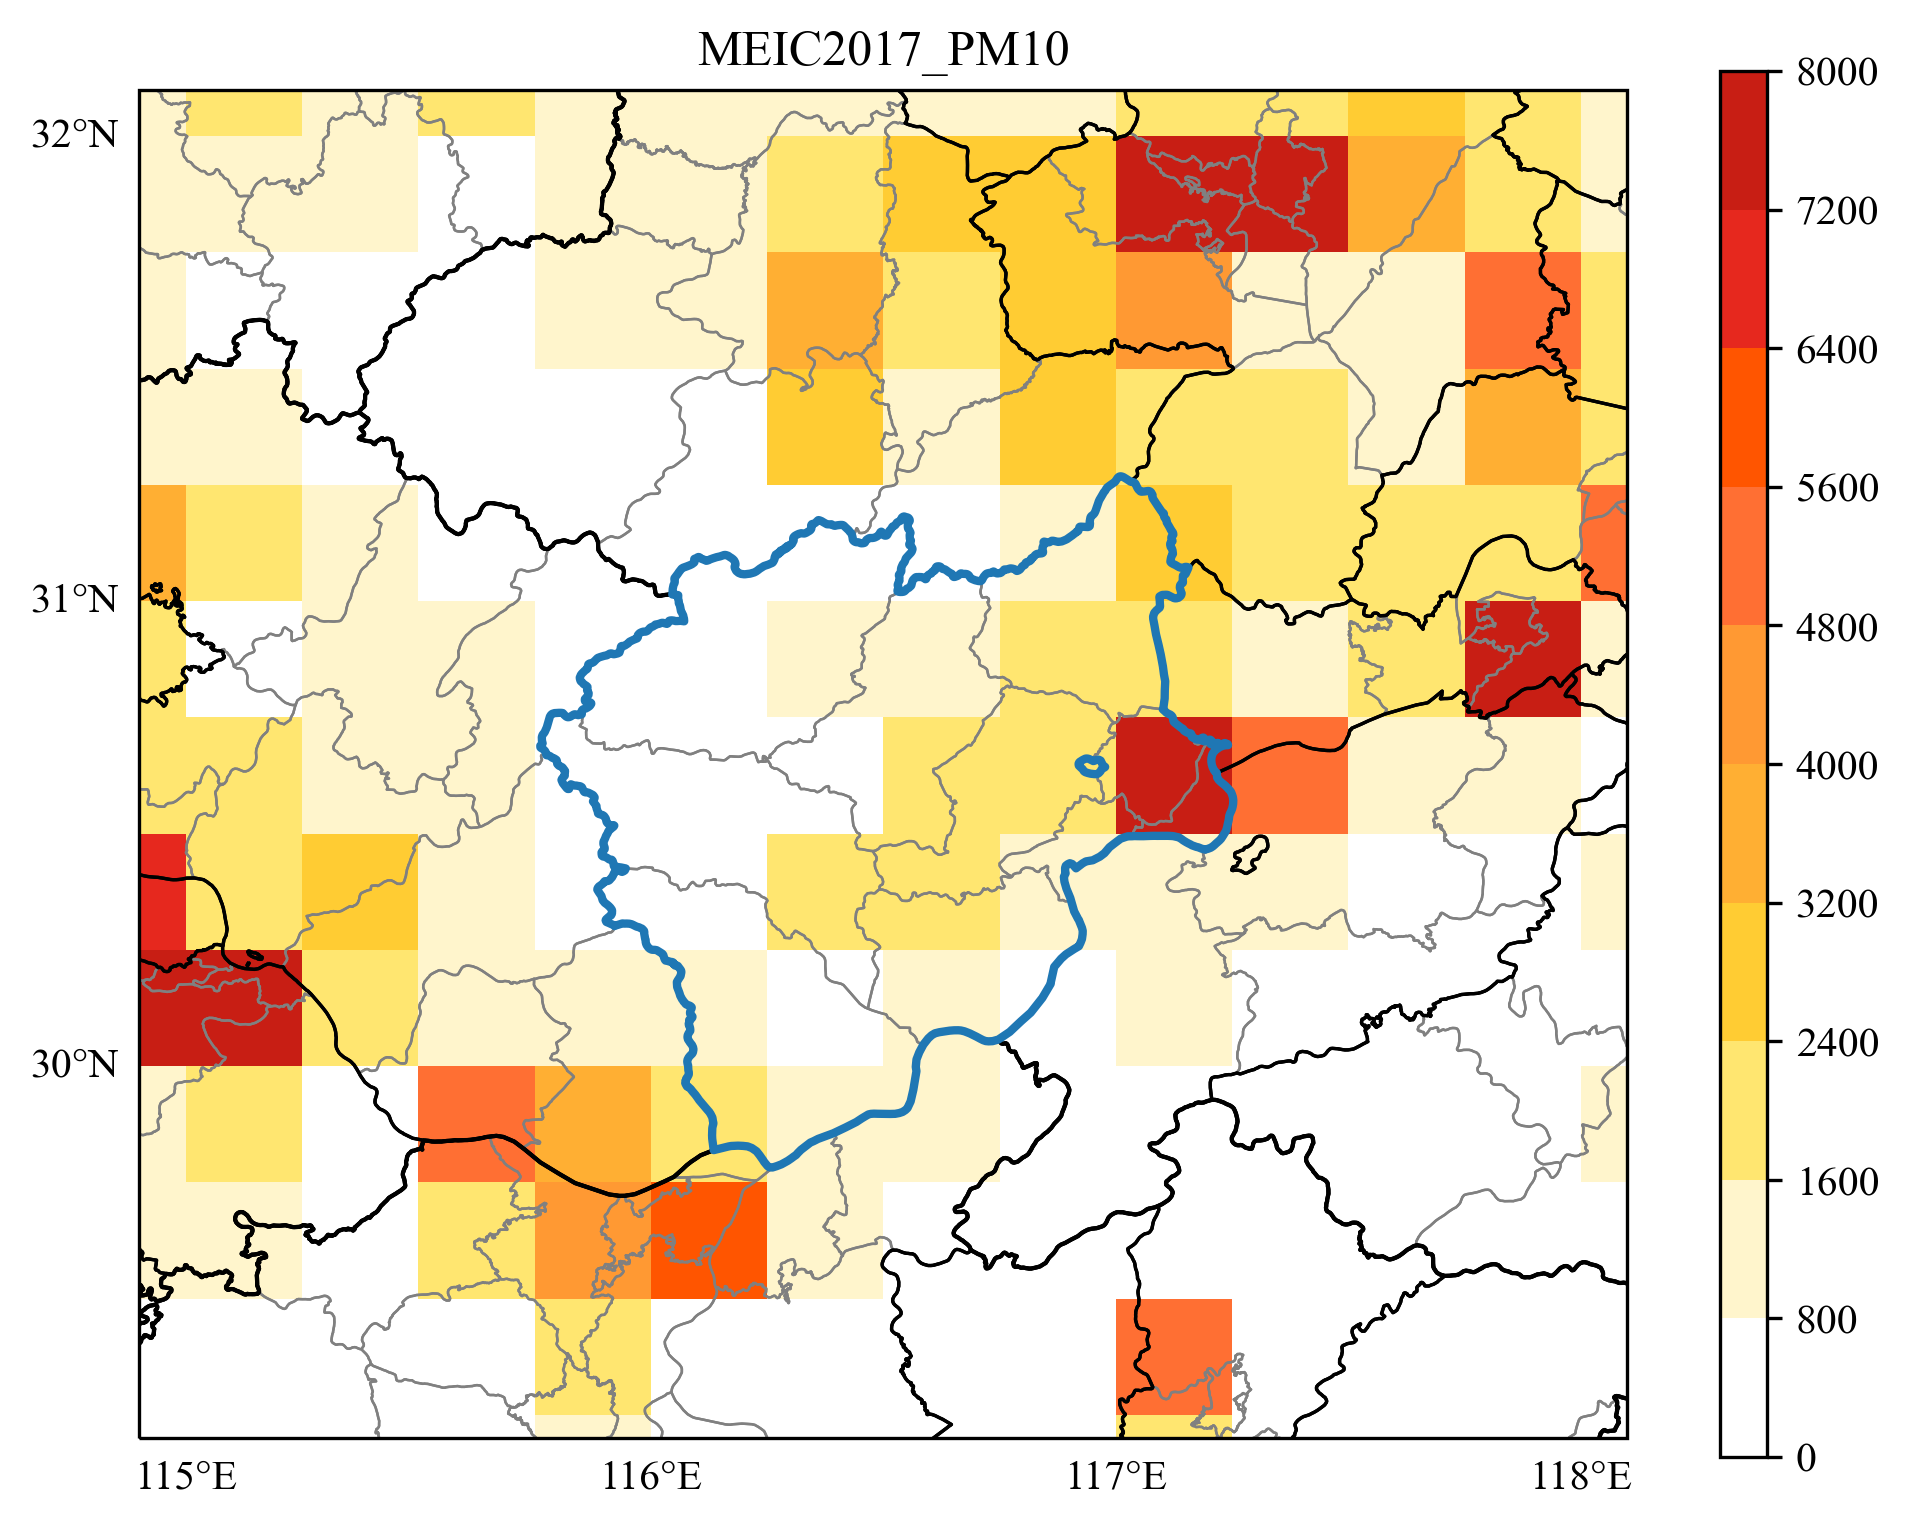

In [16]:
combining(folder_path='F:/Data/MEIC_2017_SAPRC07_0.25/',
          keyword='PM10',
          dpi=300,
          colormap=cmaps.sunshine_9lev,
          colormax=8000,
          ncolor=11)

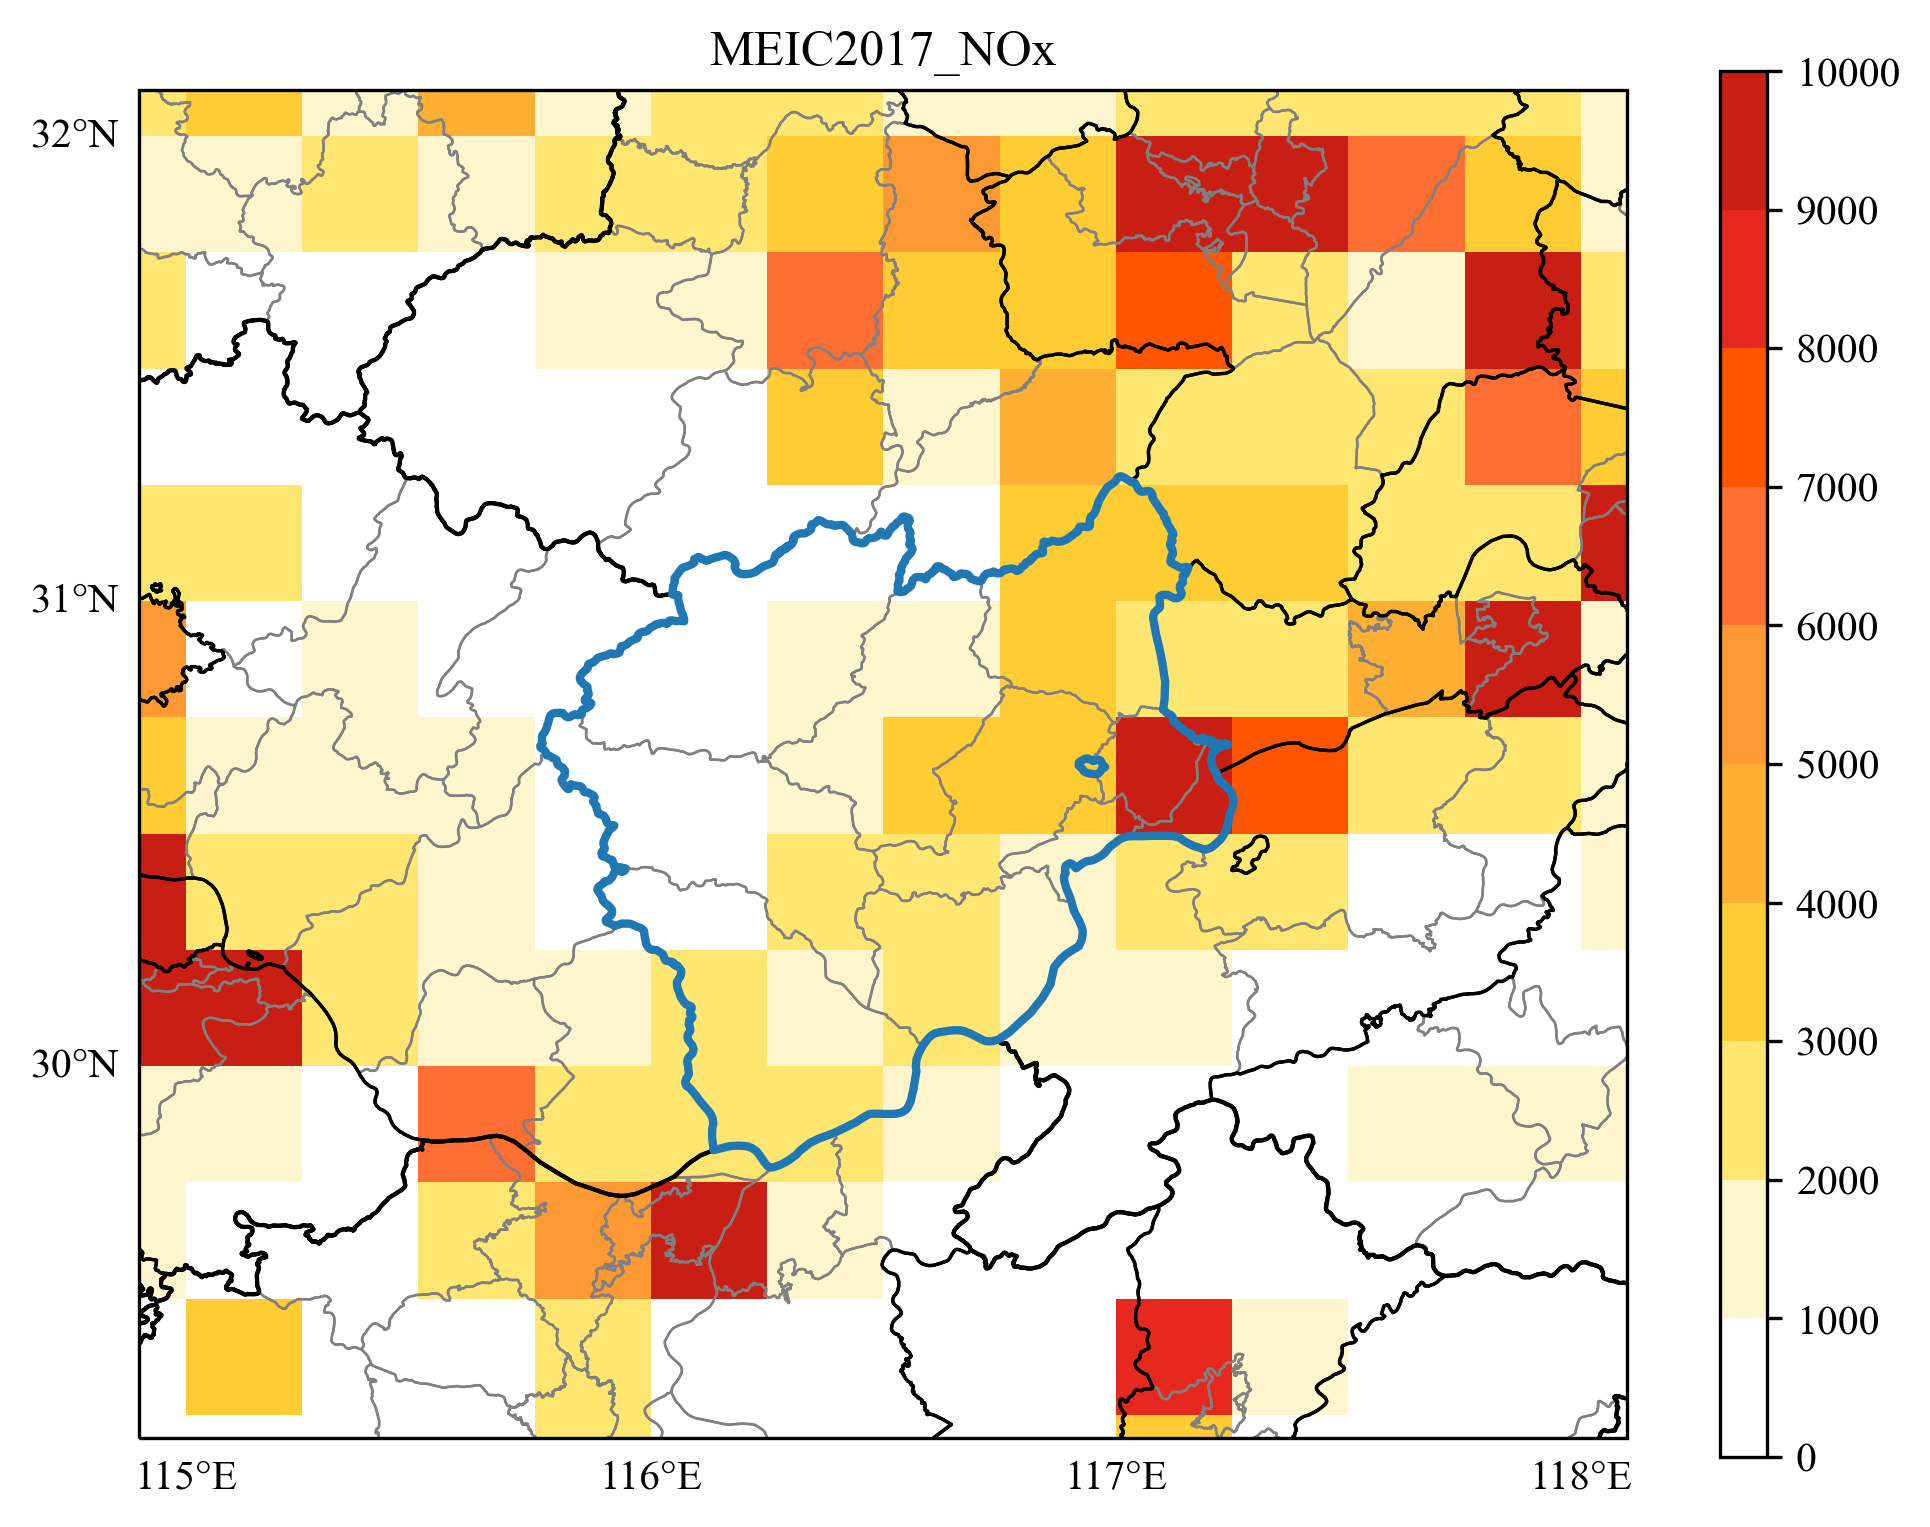

In [17]:
combining(folder_path='F:/Data/MEIC_2017_SAPRC07_0.25/',
          keyword='NOx',
          dpi=300,
          colormap=cmaps.sunshine_9lev,
          colormax=10000,
          ncolor=11)

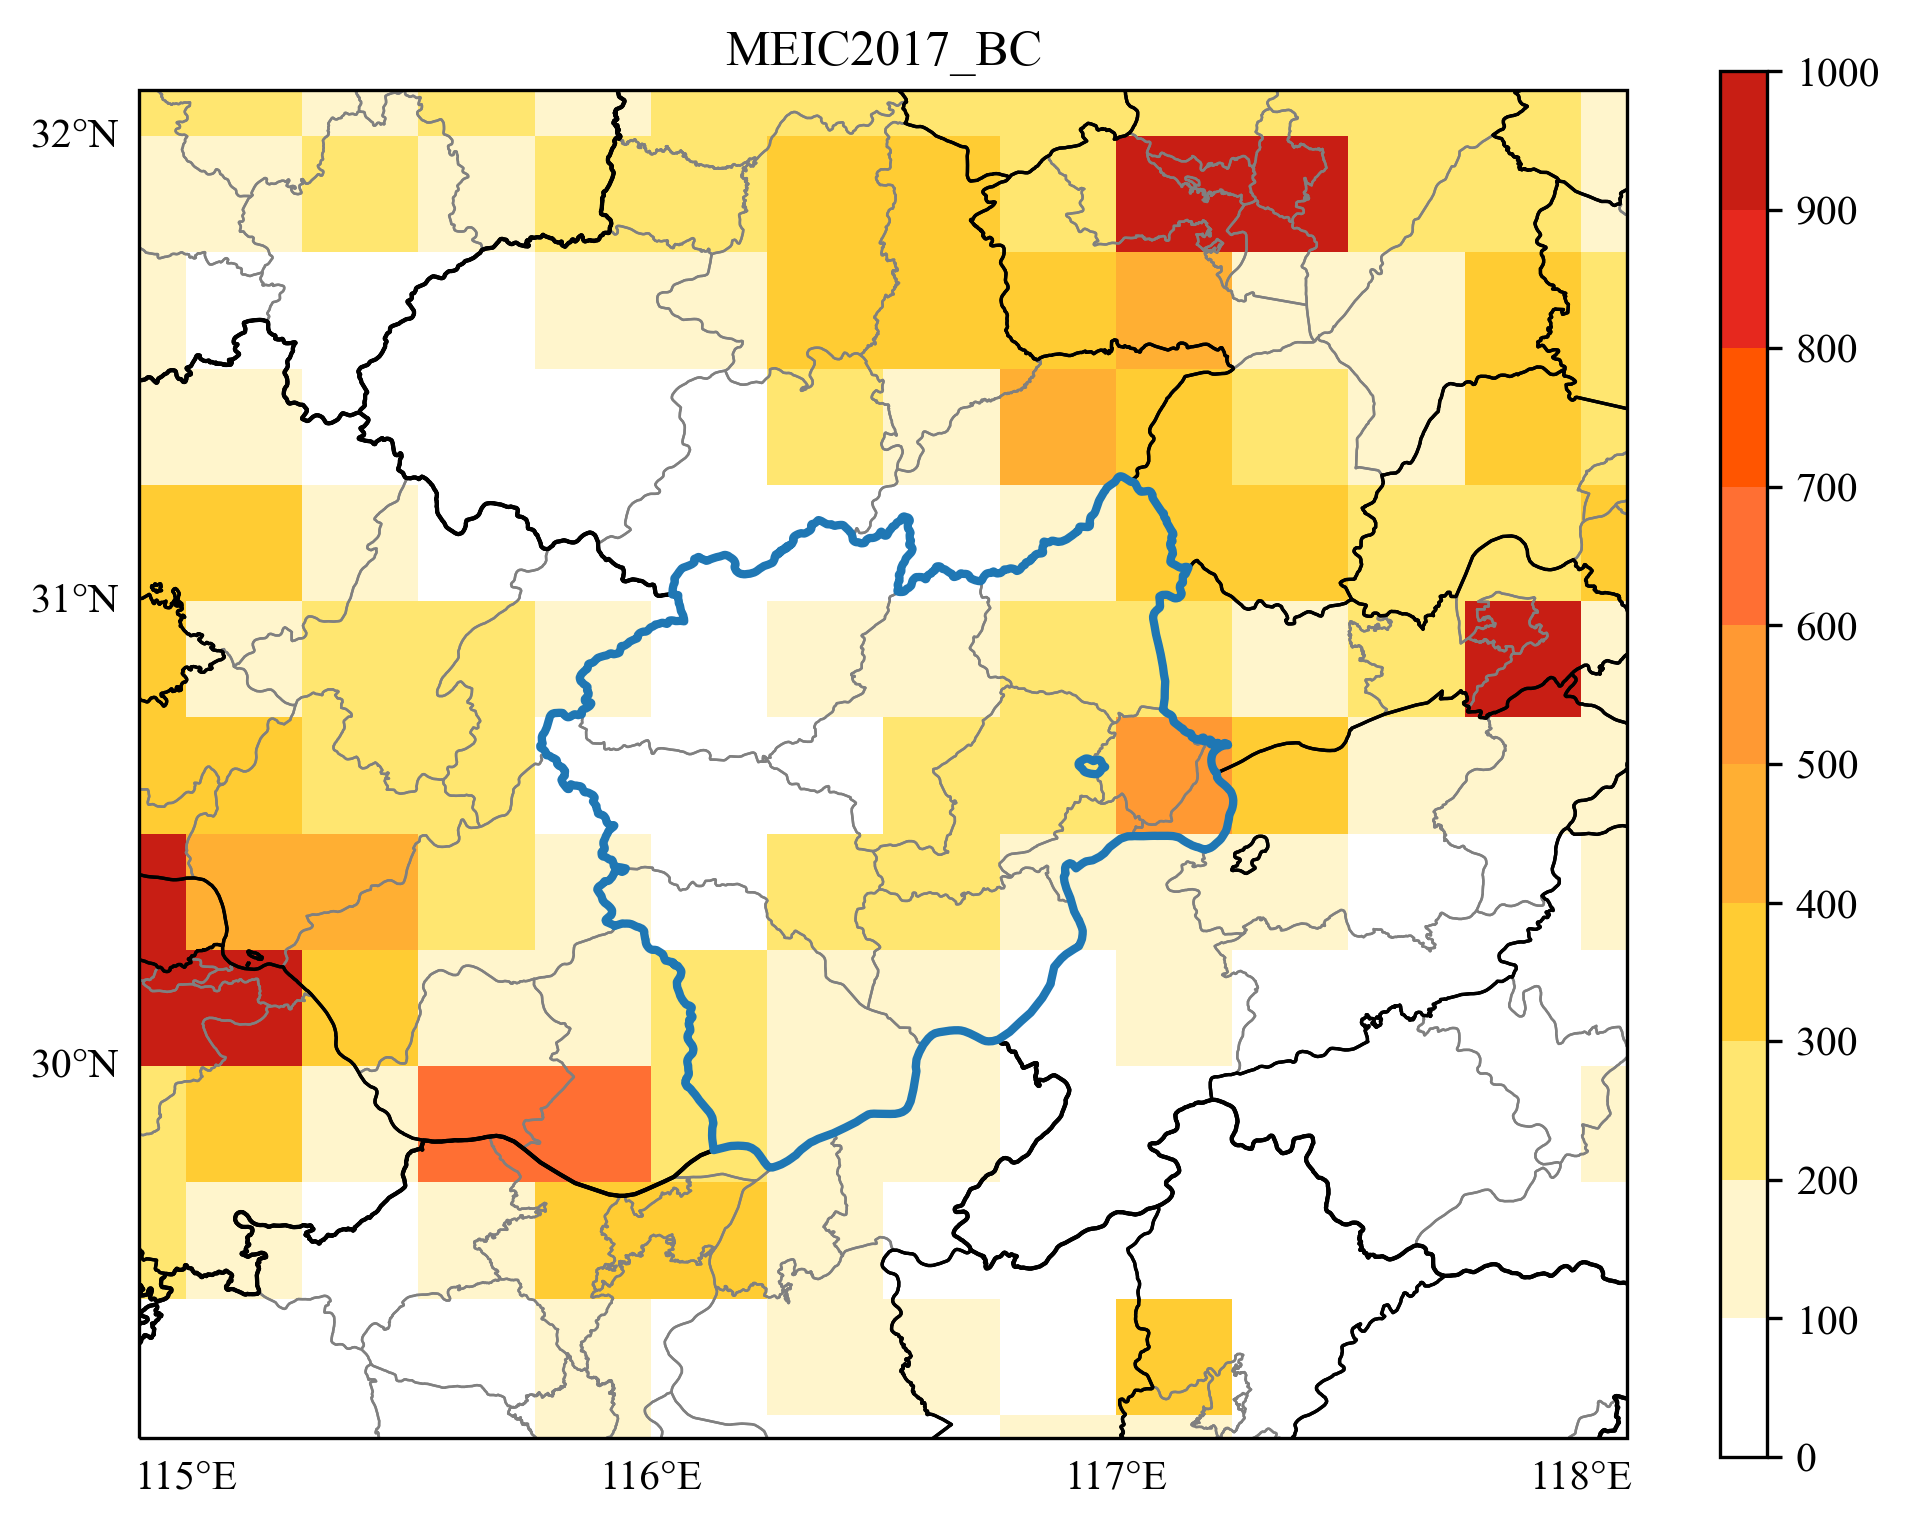

In [18]:
combining(folder_path='F:/Data/MEIC_2017_SAPRC07_0.25/',
          keyword='BC',
          dpi=300,
          colormap=cmaps.sunshine_9lev,
          colormax=1000,
          ncolor=11)

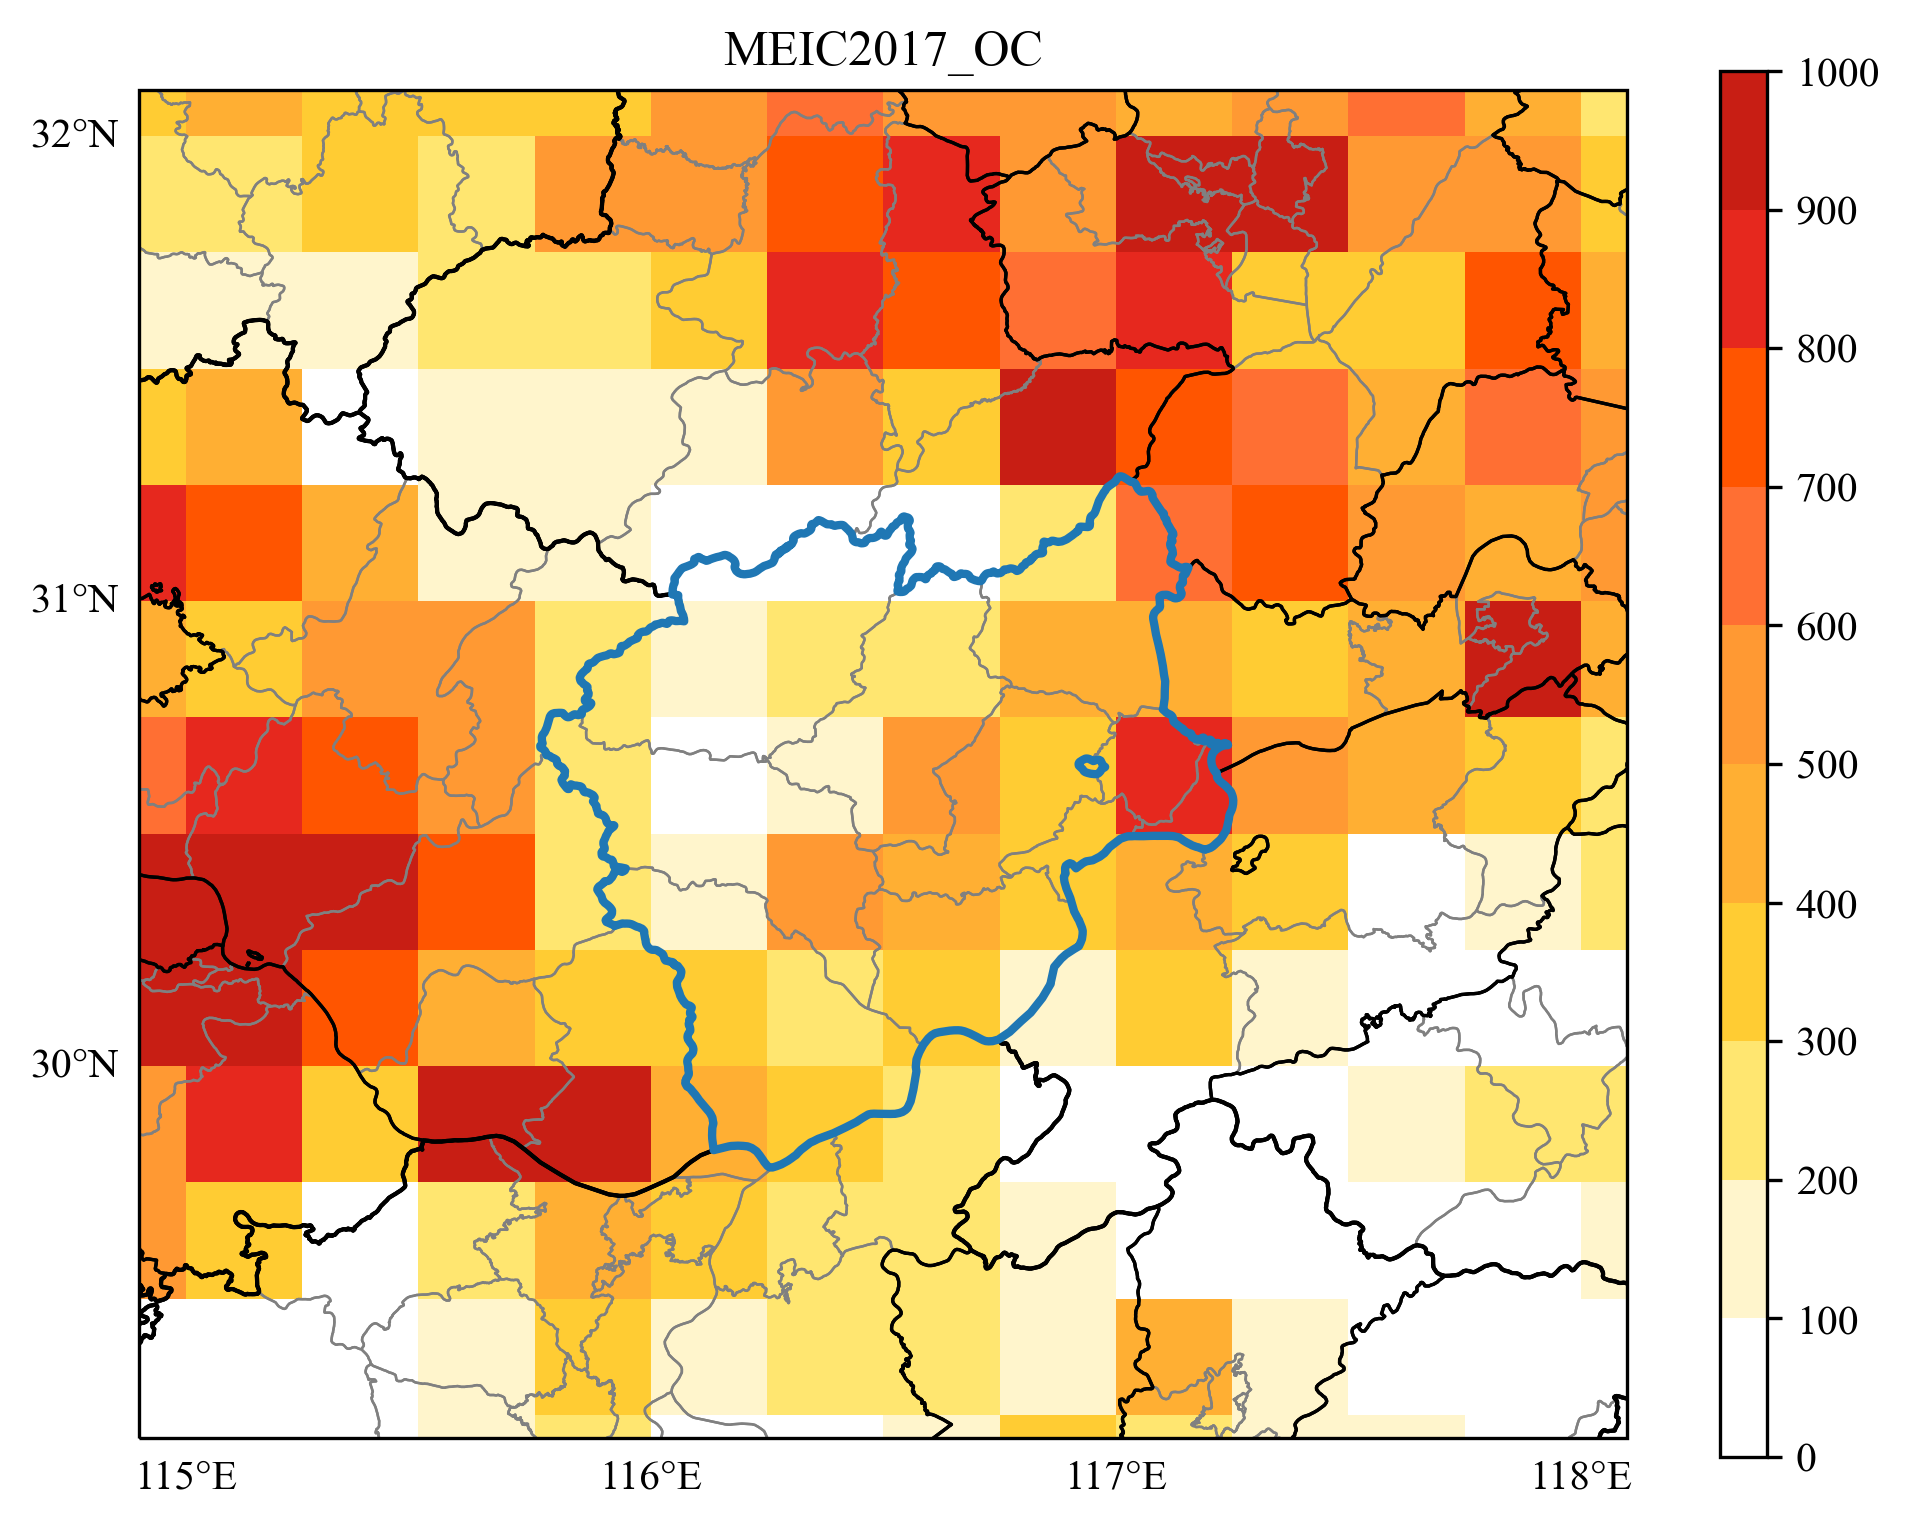

In [19]:
combining(folder_path='F:/Data/MEIC_2017_SAPRC07_0.25/',
          keyword='OC',
          dpi=300,
          colormap=cmaps.sunshine_9lev,
          colormax=1000,
          ncolor=11)

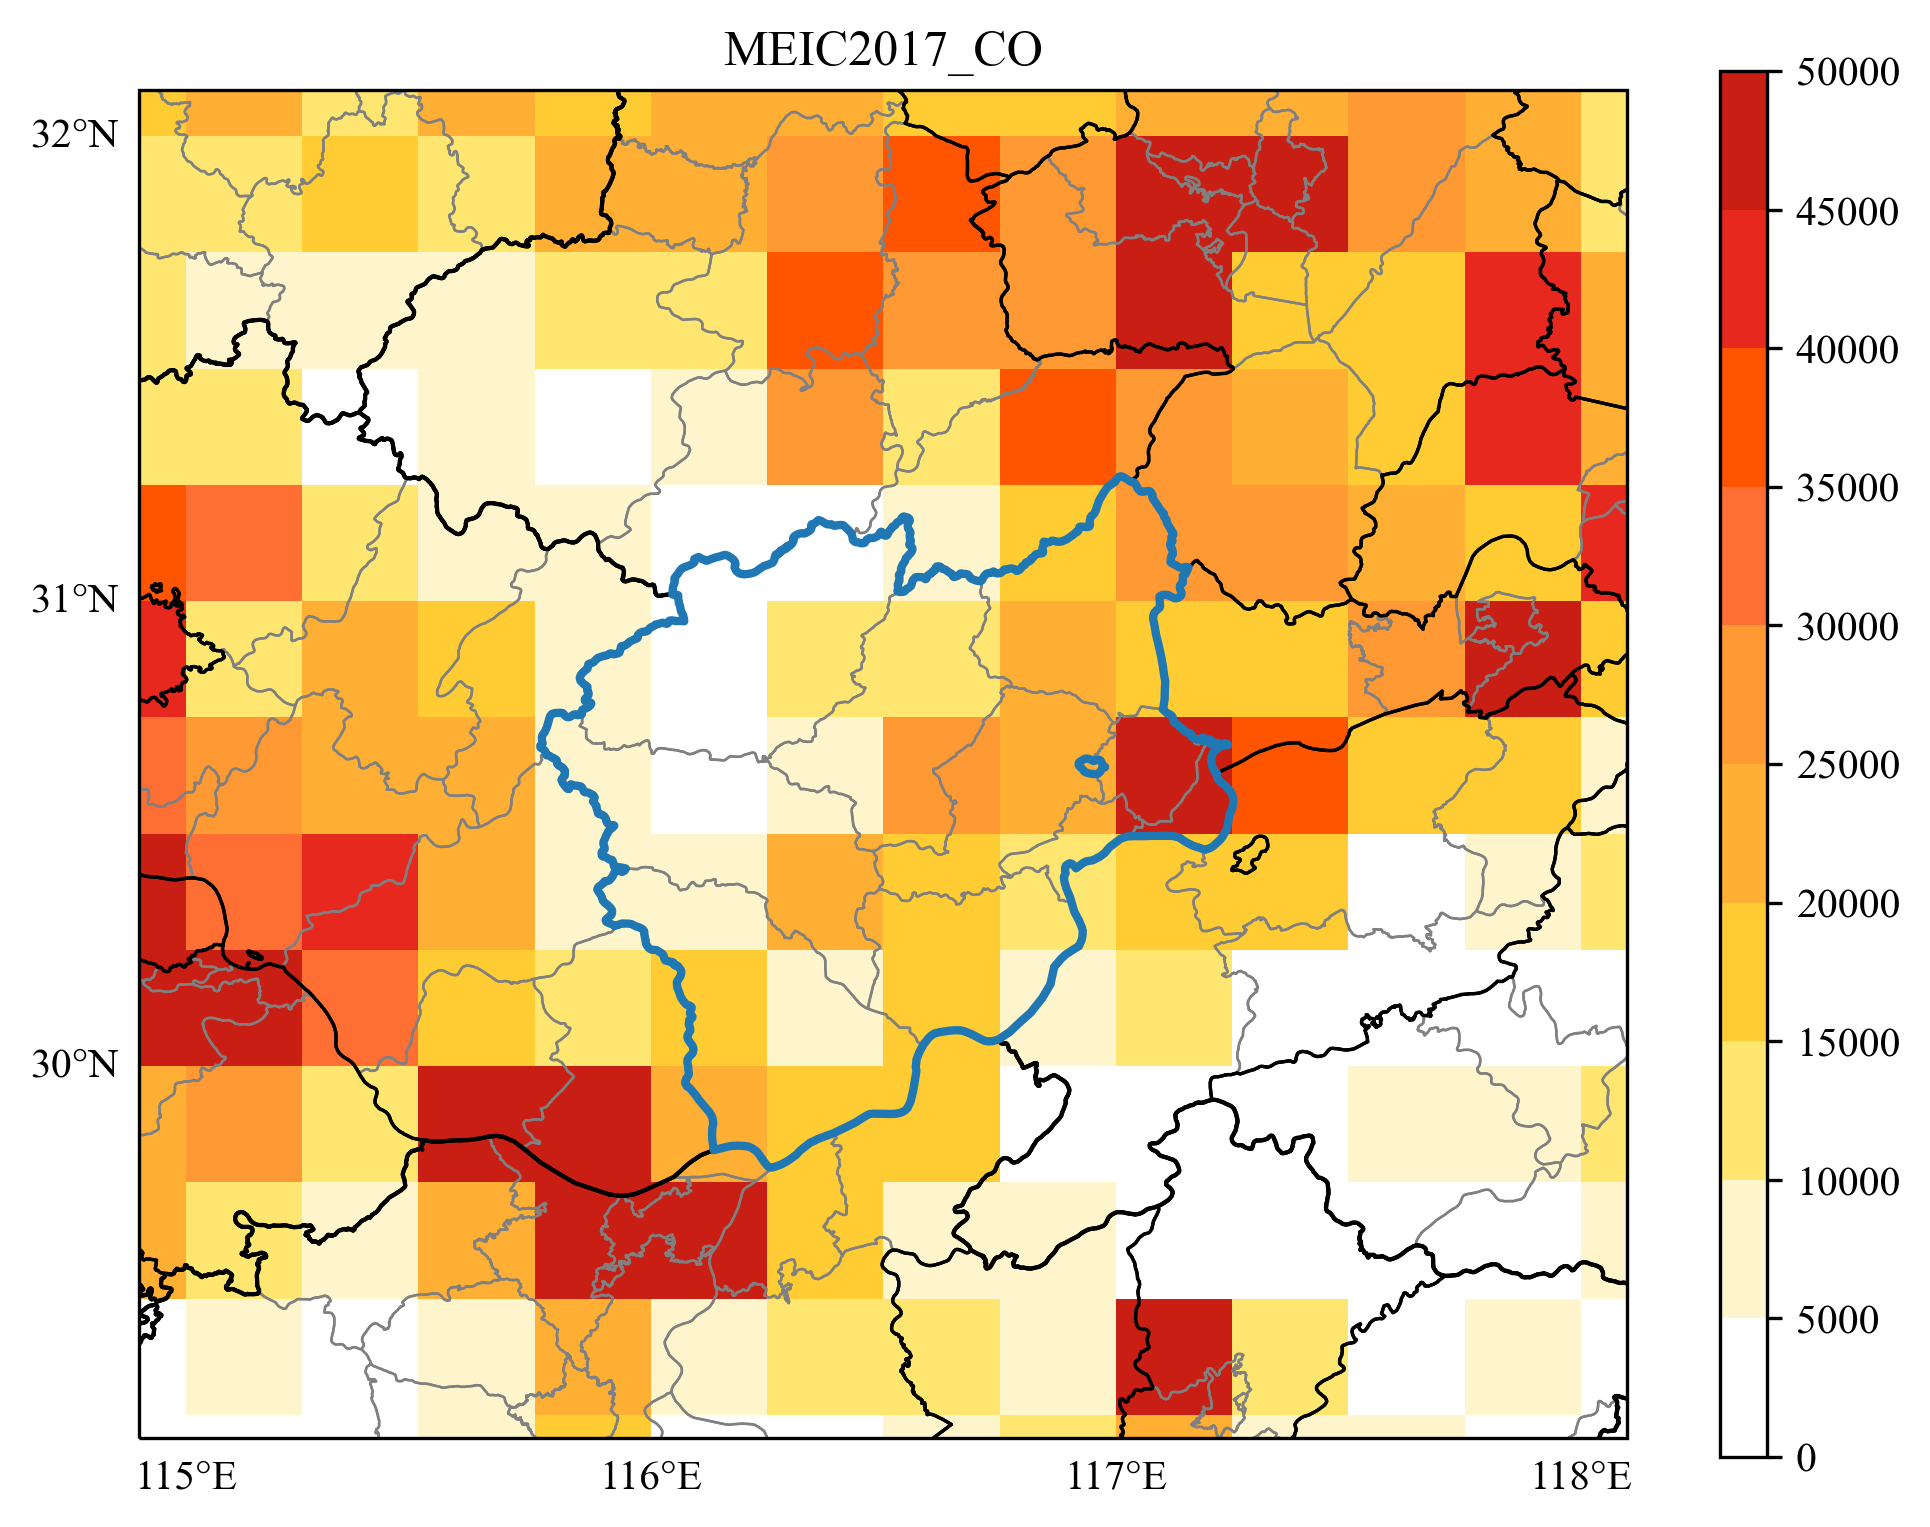

In [20]:
combining(folder_path='F:/Data/MEIC_2017_SAPRC07_0.25/',
          keyword='CO',
          dpi=300,
          colormap=cmaps.sunshine_9lev,
          colormax=50000,
          ncolor=11)

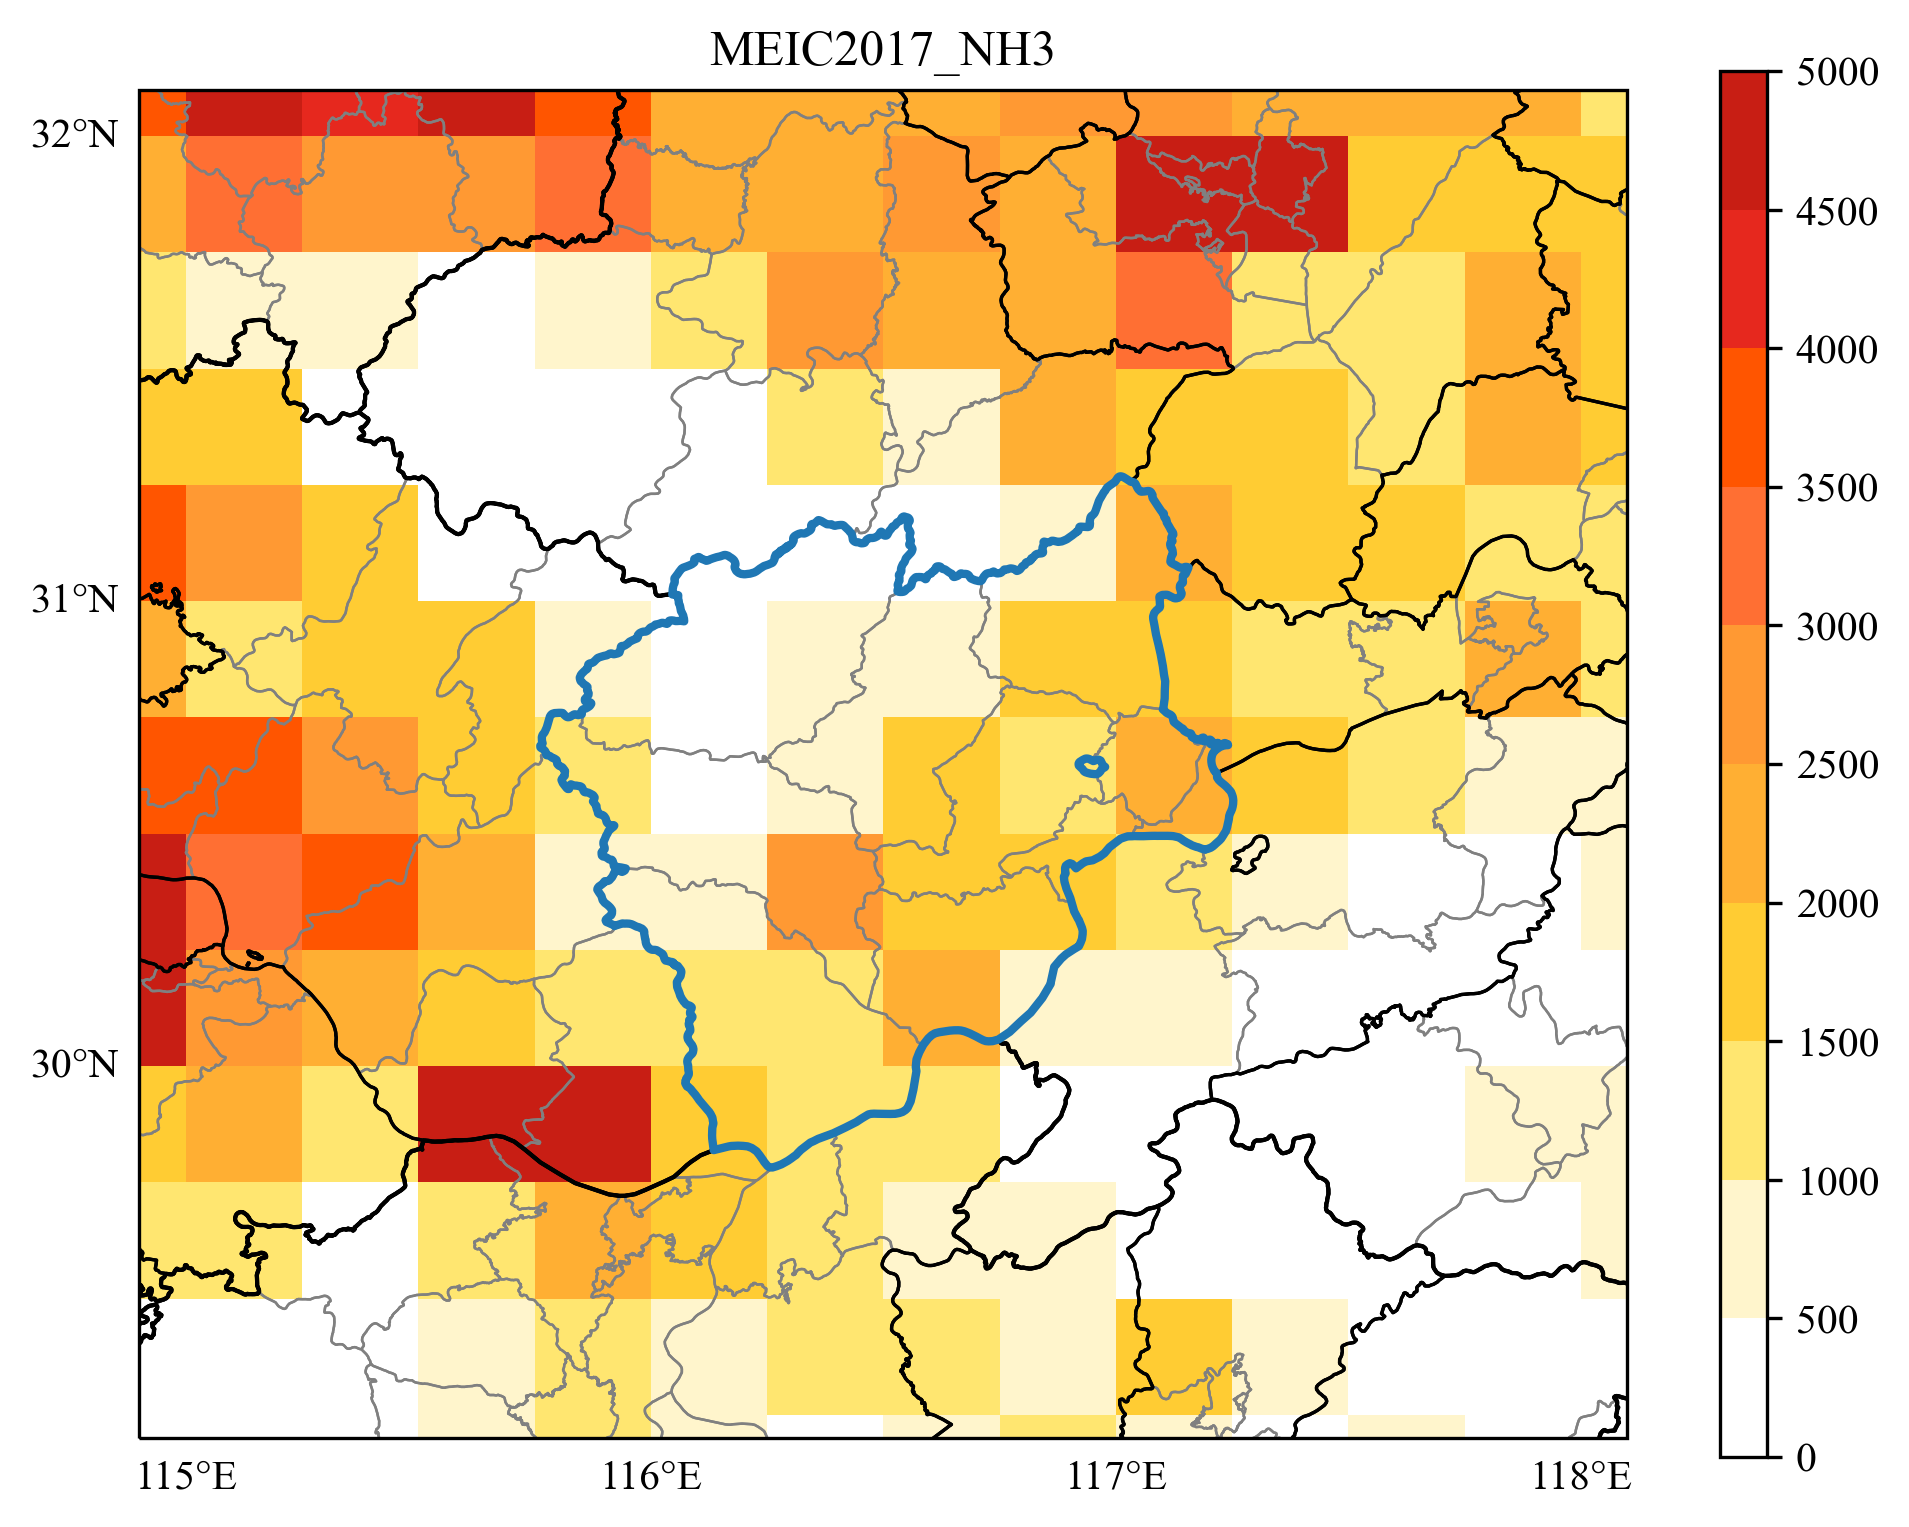

In [21]:
combining(folder_path='F:/Data/MEIC_2017_SAPRC07_0.25/',
          keyword='NH3',
          dpi=300,
          colormap=cmaps.sunshine_9lev,
          colormax=5000,
          ncolor=11)

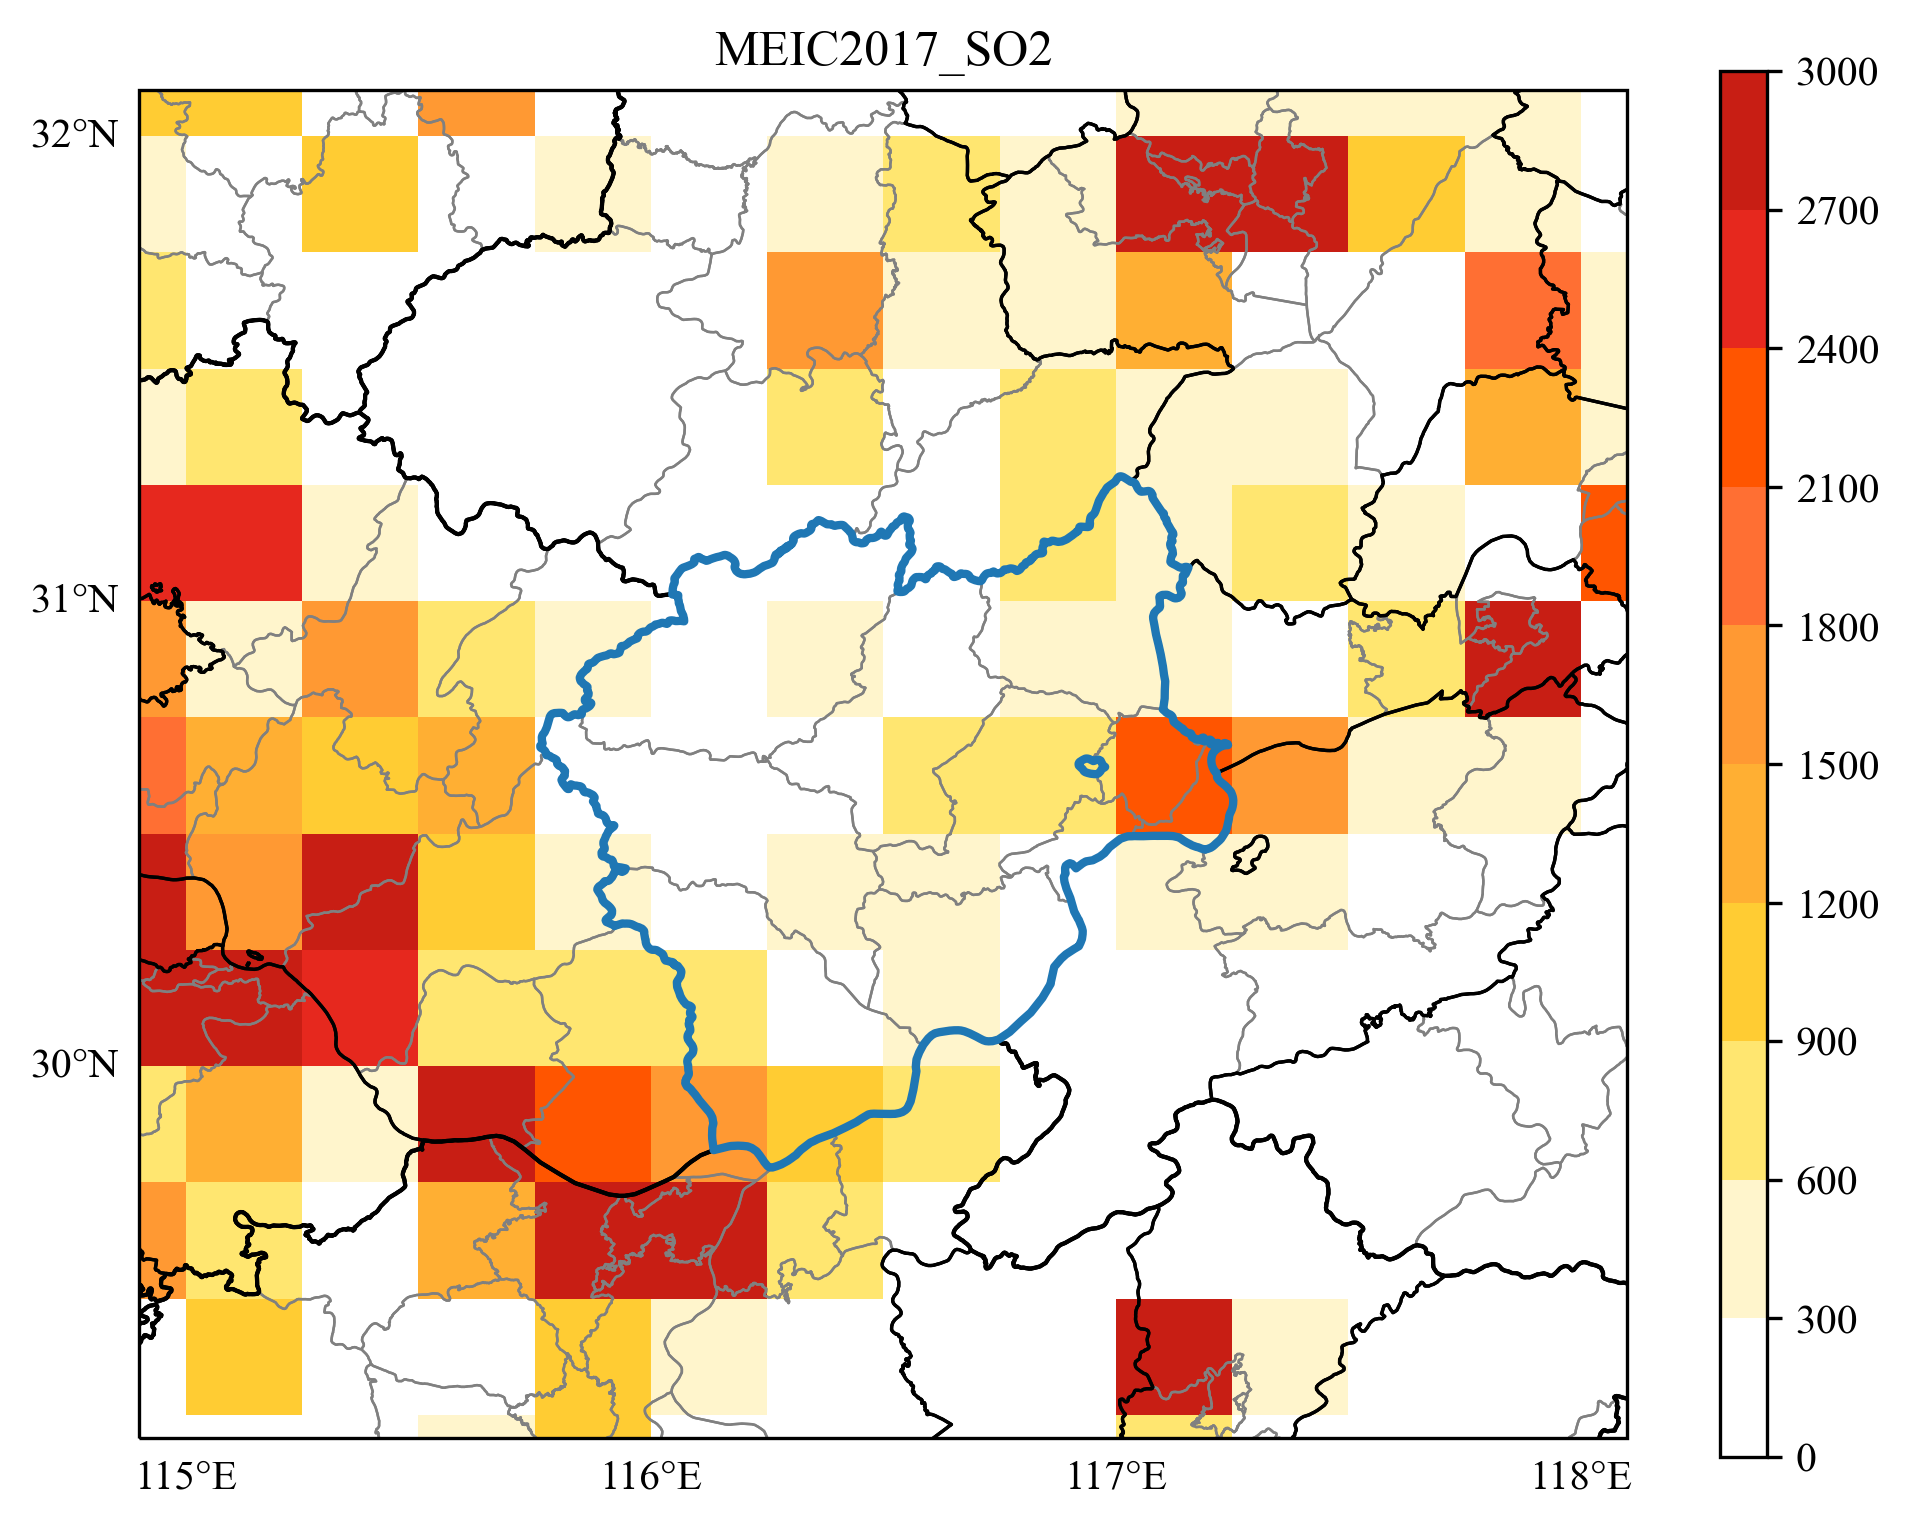

In [22]:
combining(folder_path='F:/Data/MEIC_2017_SAPRC07_0.25/',
          keyword='SO2',
          dpi=300,
          colormap=cmaps.sunshine_9lev,
          colormax=3000,
          ncolor=11)